In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import nltk
import re

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Ethan
[nltk_data]     Smith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
issues = pd.read_csv('issues.csv')

c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']

In [3]:
def assign_cluster(value):
    if value in c2_cols:
        return 2
    elif value in c3_cols:
        return 3
    else:
        return 1

In [4]:
issues['Cluster'] = issues['name_with_owner'].apply(assign_cluster)
issues

,name_with_owner,login,title,body,is_core,Cluster
0,arendst/Tasmota,cociweb,OTA upgrade is possible without authentication,<!-- Thanks for reporting a problem for this p...,0,3
1,arendst/Tasmota,ksaye,TLS Failing since commit 63c7e5f7bfb886c6ce431...,<!-- Thanks for reporting a problem for this p...,0,3
2,arendst/Tasmota,sillyfrog,Device Groups do not listen to CCT Color updates,<!-- Thanks for reporting a problem for this p...,0,3
3,arendst/Tasmota,twollweber,Add free memory to metrics for Prometheus,<!-- Thanks for reporting a problem for this p...,0,3
4,arendst/Tasmota,twollweber,Align tasmotaglobal metrics for Prometheus to ...,<!-- Thanks for reporting a problem for this p...,0,3
...,...,...,...,...,...,...
43608,yuzu-emu/yuzu,jbeich,Fails to build with Clang (due to -Werror),Regressed by #4786\r\n```c++\r\n$ c++ --versio...,0,3
43609,yuzu-emu/yuzu,ActualMandM,Missing HLE service command 'OpenDataStorageBy...,- Needed for RollerCoaster Tycoon 3: Complete...,0,3
43610,yuzu-emu/yuzu,comex,null pointer dereference in GlobalScheduler::S...,Yuzu crashes when I stop the game. The immedi...,0,3
43611,yuzu-emu/yuzu,Morph1984,Unimplemented Kernel SVC function 'UnmapShared...,- Used in Burnout Paradise,1,3


In [5]:
issues['Cluster'].value_counts()

1    28083
3     9316
2     6214
Name: Cluster, dtype: int64

In [6]:
t1 = time.time()
# Initialize the stop words, the Porter stemmer, and the set of punctuation
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
punctuation_set = set(string.punctuation)

def is_english(word):
    # Check if all characters in the word are alphabetic (English)
    return all(char.isalpha() or char.isspace() for char in word)

def preprocess_text(text):
    # Check if the text is a valid string (not NaN)
    if isinstance(text, str):
        # Replace slashes, underscores, and dots with spaces
        text = text.replace('/', ' ').replace('_', ' ').replace('.', ' ')
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
        # Create a translation table to remove punctuation within words
        translation_table = str.maketrans('', '', string.punctuation)

        # Tokenize the text
        words = word_tokenize(text)
        # Remove stop words, punctuation, and perform stemming
        filtered_words = [porter.stem(word.translate(translation_table)) for word in words if word not in stop_words]
        # Remove words containing non-English characters
        filtered_words = [word for word in filtered_words if is_english(word)]
        # Join the filtered words back into a string
        processed_text = ' '.join(filtered_words)
        return processed_text.strip().lower()  # Strip leading and trailing whitespaces
    else:
        return ''


# Apply the preprocessing function to the 'text' column
issues['processed_title'] = issues['title'].apply(preprocess_text)
issues['processed_body'] = issues['body'].apply(preprocess_text)

print("Processed text in", round((time.time() - t1) / 60, 2), "Minutes")

Processed text in 1.28 Minutes


In [7]:
empty_processed_title_rows = issues[issues['processed_title'] == '']
issue_titles = issues[issues['processed_title'] != '']

empty_processed_body_rows = issues[issues['processed_body'] == '']
issue_body = issues[issues['processed_body'] != '']

In [8]:
empty_processed_title_rows

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
235,umijs/umi,williamnie,SSR模式下dva中的数据污染，会携带其他页面的数据,在ssr模式下，dva的state数据存在污染，会携带其他页面的数据，造成页面很大，数据越来...,0,3,,复现方式 ssr的egg 例子
265,umijs/umi,Nokecy,开发模式下自动生成的404页，导致umi-plugin-dva插件查找model时间过长,https://github.com/umijs/umi/blob/513d4ad7c782...,0,3,,http github com umij umi blob packag umiplugi...
311,arendst/Tasmota,synekvl,AP1 -> AP2,Make sure these boxes are checked [x] before s...,0,3,,make sure box check x submit issu thank ...
419,umijs/umi,KellenHe,请问umi的路由配置，component可以配置成npm导出的组件吗,比如把一个组件打包成npm包并在package.json里添加依赖。\r\n在路由配置里能否...,0,3,,比如把一个组件打包成npm包并在packag 在路由配置里能否这样配置 import m...
557,umijs/umi,elivoa,SSR中无法根据cookie确定服务端渲染时用的默认locale设置。,目的是在SSR工程中，在服务端渲染阶段，服务端读取cookie中的语言设置，作为默认的语言来...,0,3,,ts中的这段 plugin umipluginreact local b...
...,...,...,...,...,...,...,...,...
29491,GIScience/openrouteservice,MichaelsJP,CVE-2022-41853,### Scope\r\n\r\npom.xml\r\n\r\n### Report Lin...,1,1,,scope pom xml report link http github com ...
32565,pokeclicker/pokeclicker,jk13pclick,#348,NaN,0,1,,
33251,Hamlib/Hamlib,mdblack98,y,NaN,1,1,,
42814,suttacentral/suttacentral,aminah-sc,#812,NaN,0,1,,


In [9]:
issue_titles

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
0,arendst/Tasmota,cociweb,OTA upgrade is possible without authentication,<!-- Thanks for reporting a problem for this p...,0,3,ota upgrad possibl without authent,thank report problem project read thi first t...
1,arendst/Tasmota,ksaye,TLS Failing since commit 63c7e5f7bfb886c6ce431...,<!-- Thanks for reporting a problem for this p...,0,3,tl fail sinc commit,thank report problem project read thi first t...
2,arendst/Tasmota,sillyfrog,Device Groups do not listen to CCT Color updates,<!-- Thanks for reporting a problem for this p...,0,3,devic group listen cct color updat,thank report problem project read thi first t...
3,arendst/Tasmota,twollweber,Add free memory to metrics for Prometheus,<!-- Thanks for reporting a problem for this p...,0,3,add free memori metric prometheu,thank report problem project read thi first t...
4,arendst/Tasmota,twollweber,Align tasmotaglobal metrics for Prometheus to ...,<!-- Thanks for reporting a problem for this p...,0,3,align tasmotaglob metric prometheu metric syntax,thank report problem project read thi first t...
...,...,...,...,...,...,...,...,...
43608,yuzu-emu/yuzu,jbeich,Fails to build with Clang (due to -Werror),Regressed by #4786\r\n```c++\r\n$ c++ --versio...,0,3,fail build clang due werror,regress c c version free bsd clang versio...
43609,yuzu-emu/yuzu,ActualMandM,Missing HLE service command 'OpenDataStorageBy...,- Needed for RollerCoaster Tycoon 3: Complete...,0,3,miss hle servic command open data storag by pr...,need roller coaster tycoon complet edit
43610,yuzu-emu/yuzu,comex,null pointer dereference in GlobalScheduler::S...,Yuzu crashes when I stop the game. The immedi...,0,3,null pointer derefer global schedul select th...,yuzu crash i stop game the immedi caus seem k...
43611,yuzu-emu/yuzu,Morph1984,Unimplemented Kernel SVC function 'UnmapShared...,- Used in Burnout Paradise,1,3,unimpl kernel svc function unmap share memori,use burnout paradis


In [10]:
empty_processed_body_rows

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
74,grafana/loki,owen-d,Log time in queue per request (metrics.go?),NaN,1,3,log time queue per request metric go,
76,grafana/loki,cyriltovena,Kafka message key should be exposed.,NaN,1,3,kafka messag key expos,
92,grafana/loki,owen-d,TSDB should support sharding,NaN,1,3,tsdb support shard,
143,grafana/loki,cyriltovena,Scrape CloudFlare Logs,NaN,1,3,scrape cloud flare log,
148,grafana/loki,owen-d,Add query metrics (`metrics.go`) for Series & ...,NaN,1,3,add queri metric metric go seri label que...,
...,...,...,...,...,...,...,...,...
43526,navikt/aksel,Lillebo,Lage Ikonknapp-komponent,NaN,1,1,lage ikonknappkompon,
43527,navikt/aksel,Lillebo,Lage Popover-komponent,NaN,1,1,lage popoverkompon,
43539,TanStack/query,TkDodo,jest -> vitest,NaN,1,3,jest vitest,
43574,yuzu-emu/yuzu,itsmeft24,a,NaN,0,3,,


In [11]:
issue_body

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
0,arendst/Tasmota,cociweb,OTA upgrade is possible without authentication,<!-- Thanks for reporting a problem for this p...,0,3,ota upgrad possibl without authent,thank report problem project read thi first t...
1,arendst/Tasmota,ksaye,TLS Failing since commit 63c7e5f7bfb886c6ce431...,<!-- Thanks for reporting a problem for this p...,0,3,tl fail sinc commit,thank report problem project read thi first t...
2,arendst/Tasmota,sillyfrog,Device Groups do not listen to CCT Color updates,<!-- Thanks for reporting a problem for this p...,0,3,devic group listen cct color updat,thank report problem project read thi first t...
3,arendst/Tasmota,twollweber,Add free memory to metrics for Prometheus,<!-- Thanks for reporting a problem for this p...,0,3,add free memori metric prometheu,thank report problem project read thi first t...
4,arendst/Tasmota,twollweber,Align tasmotaglobal metrics for Prometheus to ...,<!-- Thanks for reporting a problem for this p...,0,3,align tasmotaglob metric prometheu metric syntax,thank report problem project read thi first t...
...,...,...,...,...,...,...,...,...
43608,yuzu-emu/yuzu,jbeich,Fails to build with Clang (due to -Werror),Regressed by #4786\r\n```c++\r\n$ c++ --versio...,0,3,fail build clang due werror,regress c c version free bsd clang versio...
43609,yuzu-emu/yuzu,ActualMandM,Missing HLE service command 'OpenDataStorageBy...,- Needed for RollerCoaster Tycoon 3: Complete...,0,3,miss hle servic command open data storag by pr...,need roller coaster tycoon complet edit
43610,yuzu-emu/yuzu,comex,null pointer dereference in GlobalScheduler::S...,Yuzu crashes when I stop the game. The immedi...,0,3,null pointer derefer global schedul select th...,yuzu crash i stop game the immedi caus seem k...
43611,yuzu-emu/yuzu,Morph1984,Unimplemented Kernel SVC function 'UnmapShared...,- Used in Burnout Paradise,1,3,unimpl kernel svc function unmap share memori,use burnout paradis


In [12]:
issue_titles['is_core'].value_counts()

1    22405
0    21113
Name: is_core, dtype: int64

In [13]:
issue_body['is_core'].value_counts()

1    20607
0    20558
Name: is_core, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(issue_titles['processed_body'], issue_titles['is_core'], test_size=0.8, random_state=42)

In [15]:
# Create a Bag of Words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a classifier (Naive Bayes in this case)
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test_bow)

# Evaluate the performance
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66     16852
           1       0.68      0.75      0.71     17963

    accuracy                           0.69     34815
   macro avg       0.69      0.68      0.68     34815
weighted avg       0.69      0.69      0.68     34815



In [16]:
X_train_bow

<8703x25301 sparse matrix of type '<class 'numpy.int64'>'
	with 384921 stored elements in Compressed Sparse Row format>

In [19]:
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    compound_score = sia.polarity_scores(text)['compound']
    return compound_score

# Apply sentiment analysis to the 'text' column
issue_titles.loc[:,'title_sentiment'] = issue_titles['processed_title'].apply(get_sentiment)
issue_body.loc[:,'body_sentiment'] = issue_body['processed_body'].apply(get_sentiment)

C:\Users\Ethan Smith\AppData\Local\Temp\ipykernel_41312\2703145234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issue_titles.loc[:,'title_sentiment'] = issue_titles['processed_title'].apply(get_sentiment)
C:\Users\Ethan Smith\AppData\Local\Temp\ipykernel_41312\2703145234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issue_body.loc[:,'body_sentiment'] = issue_body['processed_body'].apply(get_sentiment)


In [20]:
issue_body

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body,body_sentiment
0,arendst/Tasmota,cociweb,OTA upgrade is possible without authentication,<!-- Thanks for reporting a problem for this p...,0,3,ota upgrad possibl without authent,thank report problem project read thi first t...,-0.9201
1,arendst/Tasmota,ksaye,TLS Failing since commit 63c7e5f7bfb886c6ce431...,<!-- Thanks for reporting a problem for this p...,0,3,tl fail sinc commit,thank report problem project read thi first t...,-0.9771
2,arendst/Tasmota,sillyfrog,Device Groups do not listen to CCT Color updates,<!-- Thanks for reporting a problem for this p...,0,3,devic group listen cct color updat,thank report problem project read thi first t...,0.9913
3,arendst/Tasmota,twollweber,Add free memory to metrics for Prometheus,<!-- Thanks for reporting a problem for this p...,0,3,add free memori metric prometheu,thank report problem project read thi first t...,-0.4019
4,arendst/Tasmota,twollweber,Align tasmotaglobal metrics for Prometheus to ...,<!-- Thanks for reporting a problem for this p...,0,3,align tasmotaglob metric prometheu metric syntax,thank report problem project read thi first t...,-0.8807
...,...,...,...,...,...,...,...,...,...
43608,yuzu-emu/yuzu,jbeich,Fails to build with Clang (due to -Werror),Regressed by #4786\r\n```c++\r\n$ c++ --versio...,0,3,fail build clang due werror,regress c c version free bsd clang versio...,-0.9987
43609,yuzu-emu/yuzu,ActualMandM,Missing HLE service command 'OpenDataStorageBy...,- Needed for RollerCoaster Tycoon 3: Complete...,0,3,miss hle servic command open data storag by pr...,need roller coaster tycoon complet edit,0.0000
43610,yuzu-emu/yuzu,comex,null pointer dereference in GlobalScheduler::S...,Yuzu crashes when I stop the game. The immedi...,0,3,null pointer derefer global schedul select th...,yuzu crash i stop game the immedi caus seem k...,0.9984
43611,yuzu-emu/yuzu,Morph1984,Unimplemented Kernel SVC function 'UnmapShared...,- Used in Burnout Paradise,1,3,unimpl kernel svc function unmap share memori,use burnout paradis,0.0000


In [21]:
issue_titles

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body,title_sentiment
0,arendst/Tasmota,cociweb,OTA upgrade is possible without authentication,<!-- Thanks for reporting a problem for this p...,0,3,ota upgrad possibl without authent,thank report problem project read thi first t...,0.0000
1,arendst/Tasmota,ksaye,TLS Failing since commit 63c7e5f7bfb886c6ce431...,<!-- Thanks for reporting a problem for this p...,0,3,tl fail sinc commit,thank report problem project read thi first t...,-0.3182
2,arendst/Tasmota,sillyfrog,Device Groups do not listen to CCT Color updates,<!-- Thanks for reporting a problem for this p...,0,3,devic group listen cct color updat,thank report problem project read thi first t...,0.0000
3,arendst/Tasmota,twollweber,Add free memory to metrics for Prometheus,<!-- Thanks for reporting a problem for this p...,0,3,add free memori metric prometheu,thank report problem project read thi first t...,0.5106
4,arendst/Tasmota,twollweber,Align tasmotaglobal metrics for Prometheus to ...,<!-- Thanks for reporting a problem for this p...,0,3,align tasmotaglob metric prometheu metric syntax,thank report problem project read thi first t...,0.0000
...,...,...,...,...,...,...,...,...,...
43608,yuzu-emu/yuzu,jbeich,Fails to build with Clang (due to -Werror),Regressed by #4786\r\n```c++\r\n$ c++ --versio...,0,3,fail build clang due werror,regress c c version free bsd clang versio...,-0.5423
43609,yuzu-emu/yuzu,ActualMandM,Missing HLE service command 'OpenDataStorageBy...,- Needed for RollerCoaster Tycoon 3: Complete...,0,3,miss hle servic command open data storag by pr...,need roller coaster tycoon complet edit,-0.1531
43610,yuzu-emu/yuzu,comex,null pointer dereference in GlobalScheduler::S...,Yuzu crashes when I stop the game. The immedi...,0,3,null pointer derefer global schedul select th...,yuzu crash i stop game the immedi caus seem k...,-0.2960
43611,yuzu-emu/yuzu,Morph1984,Unimplemented Kernel SVC function 'UnmapShared...,- Used in Burnout Paradise,1,3,unimpl kernel svc function unmap share memori,use burnout paradis,0.2960


<Axes: xlabel='is_core', ylabel='title_sentiment'>

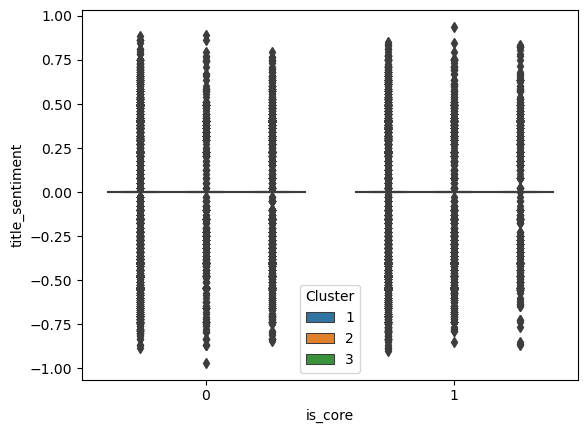

In [22]:
sns.boxplot(x='is_core', y='title_sentiment', hue = 'Cluster', data=issue_titles)

<Axes: xlabel='is_core', ylabel='body_sentiment'>

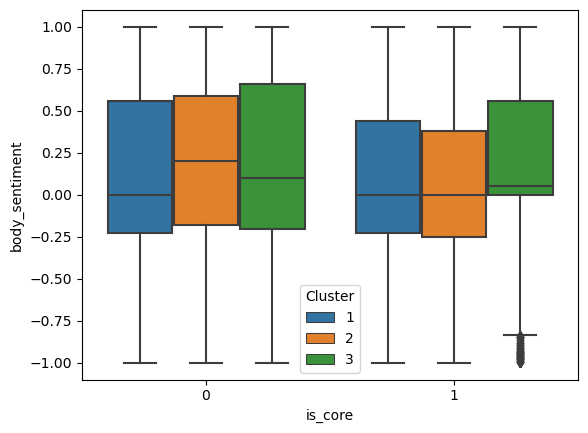

In [23]:
sns.boxplot(x='is_core', y='body_sentiment', hue = 'Cluster', data=issue_body)

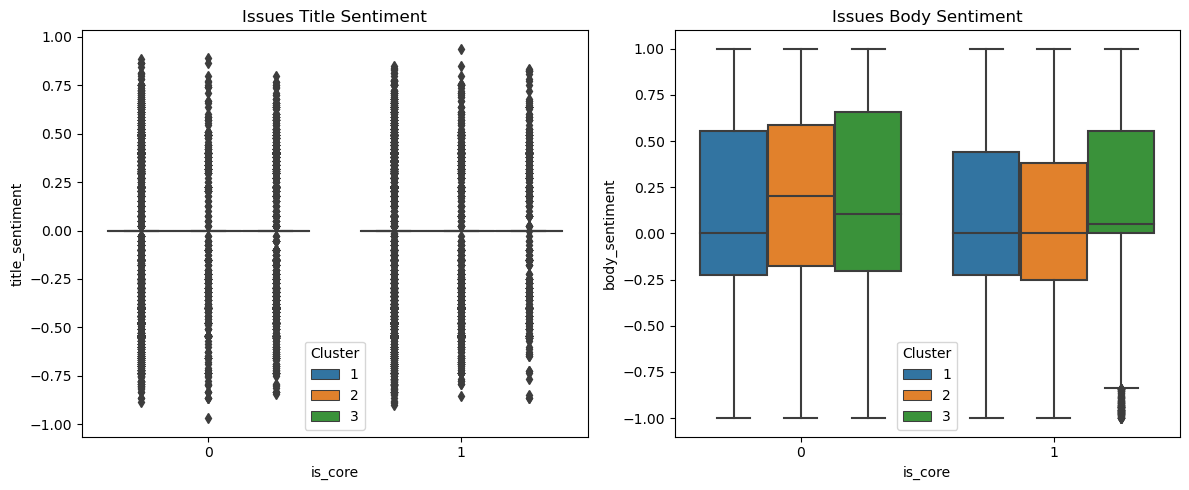

In [24]:
# Create a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='is_core', y='title_sentiment', hue='Cluster', data=issue_titles, ax=axes[0])
axes[0].set_title('Issues Title Sentiment')

# Plot the second boxplot
sns.boxplot(x='is_core', y='body_sentiment', hue='Cluster', data=issue_body, ax=axes[1])
axes[1].set_title('Issues Body Sentiment')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
non_zero = issue_titles[issue_titles['title_sentiment'] != 0]

<Axes: xlabel='is_core', ylabel='title_sentiment'>

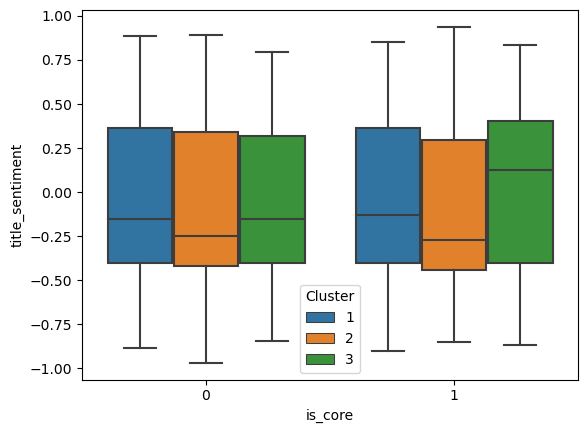

In [26]:
sns.boxplot(x='is_core', y='title_sentiment', hue = 'Cluster', data=non_zero)

In [27]:
c1 = issues[issues['Cluster'] == 1]
c2 = issues[issues['Cluster'] == 2]
c3 = issues[issues['Cluster'] == 3]

c1['is_core'].value_counts()

1    14797
0    13286
Name: is_core, dtype: int64

In [28]:
c2['is_core'].value_counts()

1    4307
0    1907
Name: is_core, dtype: int64

In [29]:
c3['is_core'].value_counts()

0    5981
1    3335
Name: is_core, dtype: int64

In [67]:
def balance_binary_class(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        idx = -1
        
        # Vectorize the data using CountVectorizer
        vectorizer = CountVectorizer()
        X_bow = vectorizer.fit_transform(balanced_data['processed_title'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_bow, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_bow, y, cv=kf, scoring='f1')
        for pred in predictions:
            scores_acc.append(pred)
        for pred in predictions2:
            scores_apre.append(pred)
    return scores_acc, scores_apre

# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc, c1_apre = balance_binary_class(c1, 'is_core')
c2_acc, c2_apre = balance_binary_class(c2, 'is_core')
c3_acc, c3_apre = balance_binary_class(c3, 'is_core')

In [68]:
def balance_binary_class_tf_idf(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        
        # Vectorize the data using TfidfVectorizer
        vectorizer = TfidfVectorizer()
        X_tfidf = vectorizer.fit_transform(balanced_data['processed_title'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='f1')
        
        scores_acc.extend(predictions)
        scores_apre.extend(predictions2)
        
    return scores_acc, scores_apre


# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc_idf, c1_apre_idf = balance_binary_class_tf_idf(c1, 'is_core')
c2_acc_idf, c2_apre_idf = balance_binary_class_tf_idf(c2, 'is_core')
c3_acc_idf, c3_apre_idf = balance_binary_class_tf_idf(c3, 'is_core')

In [69]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
accuracy_title = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
      
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)

In [70]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
f1_title = pd.DataFrame(data)

for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)

In [71]:
def balance_binary_class(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        idx = -1
        
        # Vectorize the data using CountVectorizer
        vectorizer = CountVectorizer()
        X_bow = vectorizer.fit_transform(balanced_data['processed_body'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_bow, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_bow, y, cv=kf, scoring='f1')
        for pred in predictions:
            scores_acc.append(pred)
        for pred in predictions2:
            scores_apre.append(pred)
    return scores_acc, scores_apre

# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc, c1_apre = balance_binary_class(c1, 'is_core')
c2_acc, c2_apre = balance_binary_class(c2, 'is_core')
c3_acc, c3_apre = balance_binary_class(c3, 'is_core')

In [72]:
def balance_binary_class_tf_idf(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        
        # Vectorize the data using TfidfVectorizer
        vectorizer = TfidfVectorizer()
        X_tfidf = vectorizer.fit_transform(balanced_data['processed_body'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='f1')
        
        scores_acc.extend(predictions)
        scores_apre.extend(predictions2)
        
    return scores_acc, scores_apre


# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc_idf, c1_apre_idf = balance_binary_class_tf_idf(c1, 'is_core')
c2_acc_idf, c2_apre_idf = balance_binary_class_tf_idf(c2, 'is_core')
c3_acc_idf, c3_apre_idf = balance_binary_class_tf_idf(c3, 'is_core')

In [73]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
accuracy_body = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
      
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)

In [74]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
f1_body = pd.DataFrame(data)

for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)

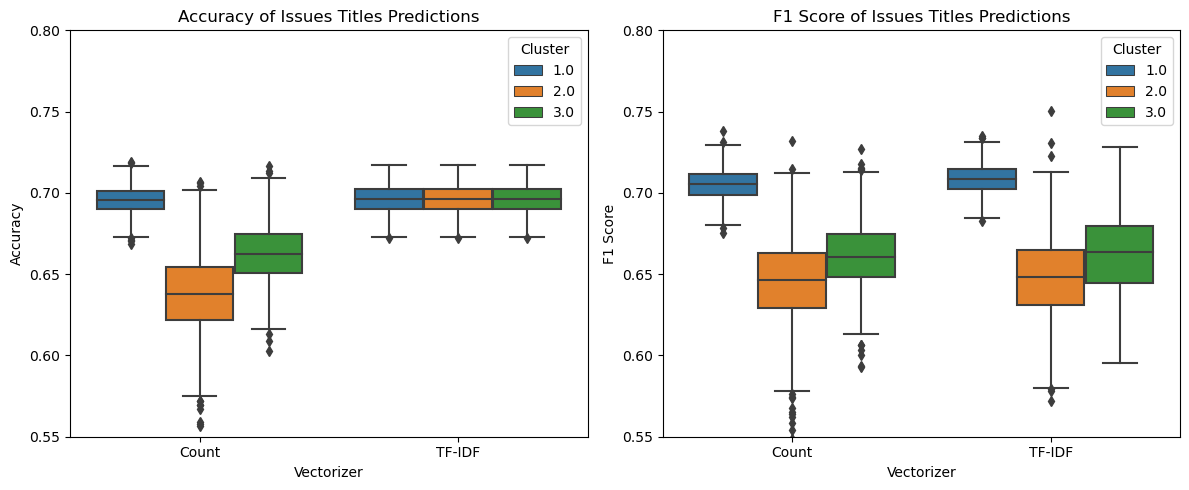

In [75]:
# Create a subplot grid
new_xtick_labels = ['Count', 'TF-IDF']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=accuracy_title, ax=axes[0])
axes[0].set_title('Accuracy of Issues Titles Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.55, 0.8)
axes[0].set_xlabel("Vectorizer")
axes[0].set_ylabel("Accuracy")

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=f1_title, ax=axes[1])
axes[1].set_title('F1 Score of Issues Titles Predictions')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.55, 0.8)
axes[1].set_xlabel("Vectorizer")
axes[1].set_ylabel("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

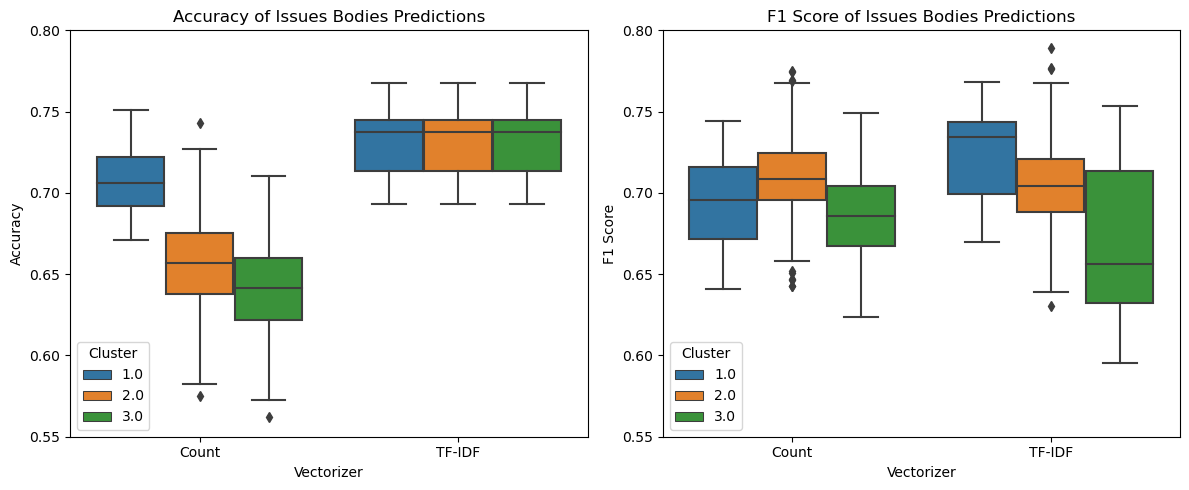

In [76]:
# Create a subplot grid
new_xtick_labels = ['Count', 'TF-IDF']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=accuracy_body, ax=axes[0])
axes[0].set_title('Accuracy of Issues Bodies Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.55, 0.8)
axes[0].set_xlabel("Vectorizer")
axes[0].set_ylabel("Accuracy")

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=f1_body, ax=axes[1])
axes[1].set_title('F1 Score of Issues Bodies Predictions')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.55, 0.8)
axes[1].set_xlabel("Vectorizer")
axes[1].set_ylabel("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [61]:
f1_body

,Score,Metric,Cluster
0,0.663145,0.0,1.0
1,0.669384,0.0,1.0
2,0.709356,0.0,1.0
3,0.729368,0.0,1.0
4,0.711212,0.0,1.0
...,...,...,...
5995,0.632509,1.0,3.0
5996,0.718480,1.0,3.0
5997,0.613240,1.0,3.0
5998,0.745098,1.0,3.0


In [40]:
vectorizer = CountVectorizer()
core_titles = issue_titles[issue_titles['is_core'] == 1]
title_words = vectorizer.fit_transform(core_titles['processed_title'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts across all documents
word_counts = title_words.sum(axis=0)

# Create a DataFrame to display the top 25 most common words with counts
top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.tolist()[0]})
top_words_df = top_words_df.sort_values(by='Count', ascending=False).head(50)

# Display the top 25 most common words
print(top_words_df)

          Word  Count
76         add   1792
7765      test   1288
2507     error   1112
8395       use   1066
5185        nt   1038
8357     updat   1017
1598     creat    893
7592   support    843
2663      fail    807
6452   resourc    750
4967       new    740
2756      file    709
8399      user    671
1772      data    664
6926       set    662
8783      work    613
7012      show    586
5134  notebook    565
4424     manag    562
292        api    554
1109     chang    533
6378     remov    527
911        bug    521
5439      page    515
5016      node    505
6072     queri    477
1443   connect    475
3161     graph    474
4901      name    464
6827    search    462
1013      card    458
8122      type    452
949     button    449
3564    import    446
8526      view    414
2331      edit    413
3049       get    408
5341    option    404
4232      list    399
6861    select    398
5312      open    391
916      build    390
5911   project    387
2797       fix    385
6408    re

In [41]:
vectorizer = CountVectorizer()
core_titles = issue_titles[issue_titles['is_core'] == 0]
title_words = vectorizer.fit_transform(core_titles['processed_title'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts across all documents
word_counts = title_words.sum(axis=0)

# Create a DataFrame to display the top 25 most common words with counts
top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.tolist()[0]})
top_words_df = top_words_df.sort_values(by='Count', ascending=False).head(50)

# Display the top 25 most common words
print(top_words_df)

          Word  Count
76         add   1514
9164       use   1143
2734     error   1140
973        bug    899
5730        nt    822
8277   support    709
9673      work    667
9129     updat    662
7563       set    619
8836      type    596
7070   request    586
1725     creat    539
2904      fail    539
3023      file    537
1191     chang    506
2963    featur    500
5486       new    495
8488      test    486
1922      data    480
5381      name    464
6014      page    460
7652      show    445
1002    button    433
9168      user    430
3395       get    427
2162     devic    421
9222      valu    416
320        api    409
4228      issu    405
1856    custom    404
7486    select    398
3012     field    393
1559   connect    393
5774    object    386
4686      list    384
5133      miss    382
4671      link    381
6716     queri    368
7100   resourc    364
5915    option    351
3266  function    351
2257   display    342
192      allow    338
9324      view    338
4875      